In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from statsmodels.stats.weightstats import ztest
import seaborn as sns
import numpy as np
from sklearn.linear_model import BayesianRidge
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error





In [2]:
features_train = pd.read_csv("dengue_features_train.csv")
labels_train   = pd.read_csv("dengue_labels_train.csv")
features_test  = pd.read_csv("dengue_features_test.csv")

print("Features train shape:", features_train.shape)
print("Labels train shape:  ", labels_train.shape)
print("Features test shape: ", features_test.shape)

print("\nFeatures train columns:\n", features_train.columns)
print("\nLabels train columns:\n", labels_train.columns)

Features train shape: (1456, 24)
Labels train shape:   (1456, 4)
Features test shape:  (416, 24)

Features train columns:
 Index(['city', 'year', 'weekofyear', 'week_start_date', 'ndvi_ne', 'ndvi_nw',
       'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm'],
      dtype='object')

Labels train columns:
 Index(['city', 'year', 'weekofyear', 'total_cases'], dtype='object')


In [3]:
train = features_train.merge(
    labels_train,
    on=["city", "year", "weekofyear"],
    how="left"
)

print("Merged train shape:", train.shape)
train.head()

Merged train shape: (1456, 25)


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


In [7]:
#Converting week_start_date to datetime
train["week_start_date"] = pd.to_datetime(train["week_start_date"])
features_test["week_start_date"] = pd.to_datetime(features_test["week_start_date"])
train["week_start_date"]
#Sorting by city and time
train = train.sort_values(["city", "year", "weekofyear"]).reset_index(drop=True)
features_test = features_test.sort_values(["city", "year", "weekofyear"]).reset_index(drop=True)

train.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,iq,2000,26,2000-07-01,0.192886,0.132257,0.340886,0.247200,25.41,296.740000,...,92.418571,25.41,16.651429,8.928571,26.400000,10.775000,32.5,20.7,3.0,0
1,iq,2000,27,2000-07-08,0.216833,0.276100,0.289457,0.241657,60.61,296.634286,...,93.581429,60.61,16.862857,10.314286,26.900000,11.566667,34.0,20.8,55.6,0
2,iq,2000,28,2000-07-15,0.176757,0.173129,0.204114,0.128014,55.52,296.415714,...,95.848571,55.52,17.120000,7.385714,26.800000,11.466667,33.0,20.7,38.1,0
3,iq,2000,29,2000-07-22,0.227729,0.145429,0.254200,0.200314,5.60,295.357143,...,87.234286,5.60,14.431429,9.114286,25.766667,10.533333,31.5,14.7,30.0,0
4,iq,2000,30,2000-07-29,0.328643,0.322129,0.254371,0.361043,62.76,296.432857,...,88.161429,62.76,15.444286,9.500000,26.600000,11.480000,33.3,19.1,4.0,0


In [9]:
train["city"]

0       iq
1       iq
2       iq
3       iq
4       iq
        ..
1451    sj
1452    sj
1453    sj
1454    sj
1455    sj
Name: city, Length: 1456, dtype: object

In [11]:
train.groupby("city").size()

city
iq    520
sj    936
dtype: int64

In [13]:

if "city" not in train.columns:
    train = train.reset_index()

if "city" not in features_test.columns:
    features_test = features_test.reset_index()

print("Train columns (first few):", train.columns[:8])
print("Test columns (first few):", features_test.columns[:8])

city_encoder = LabelEncoder()

train["city"] = city_encoder.fit_transform(train["city"])
features_test["city"] = city_encoder.transform(features_test["city"])

print("\nCity classes mapping:", dict(enumerate(city_encoder.classes_)))

for df in (train, features_test):
    if "week_start_date" in df.columns:
        df.drop(columns=["week_start_date"], inplace=True)

print("\nColumns after dropping week_start_date:")
print(train.columns)
X = train.drop(columns=["total_cases"])
y = train["total_cases"]

print("\nX shape:", X.shape)
print("y shape:", y.shape)

X_train = X[X["year"] < 2008].copy()
y_train = y[X["year"] < 2008].copy()

X_valid = X[X["year"] == 2008].copy()
y_valid = y[X["year"] == 2008].copy()

print("\nTrain samples:", len(X_train))
print("Valid samples:", len(X_valid))

print("\nCheck a few rows of X_train:")
print(X_train)

Train columns (first few): Index(['city', 'year', 'weekofyear', 'week_start_date', 'ndvi_ne', 'ndvi_nw',
       'ndvi_se', 'ndvi_sw'],
      dtype='object')
Test columns (first few): Index(['city', 'year', 'weekofyear', 'week_start_date', 'ndvi_ne', 'ndvi_nw',
       'ndvi_se', 'ndvi_sw'],
      dtype='object')

City classes mapping: {0: 'iq', 1: 'sj'}

Columns after dropping week_start_date:
Index(['city', 'year', 'weekofyear', 'ndvi_ne', 'ndvi_nw', 'ndvi_se',
       'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm', 'total_cases'],
     

In [15]:
rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1 
)

#Training
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=500, n_jobs=-1, random_state=42)

In [16]:
#Predicting on validation data
y_pred = rf.predict(X_valid)

#Calculating MAE
mae = mean_absolute_error(y_valid, y_pred)
print("Validation MAE (2008):", mae)

Validation MAE (2008): 10.427159420289858


In [19]:

valid_df = X_valid.copy()
valid_df["true_cases"] = y_valid.values
valid_df["pred_cases"] = y_pred

mae_by_city = (
    valid_df
    .groupby("city")[["true_cases", "pred_cases"]]
    .apply(lambda g: mean_absolute_error(g["true_cases"], g["pred_cases"]))
)

print("MAE by city (encoded):")
print(mae_by_city)

MAE by city (encoded):
city
0    12.299077
1     4.701294
dtype: float64


In [21]:
print(dict(enumerate(city_encoder.classes_)))

{0: 'iq', 1: 'sj'}


<Axes: >

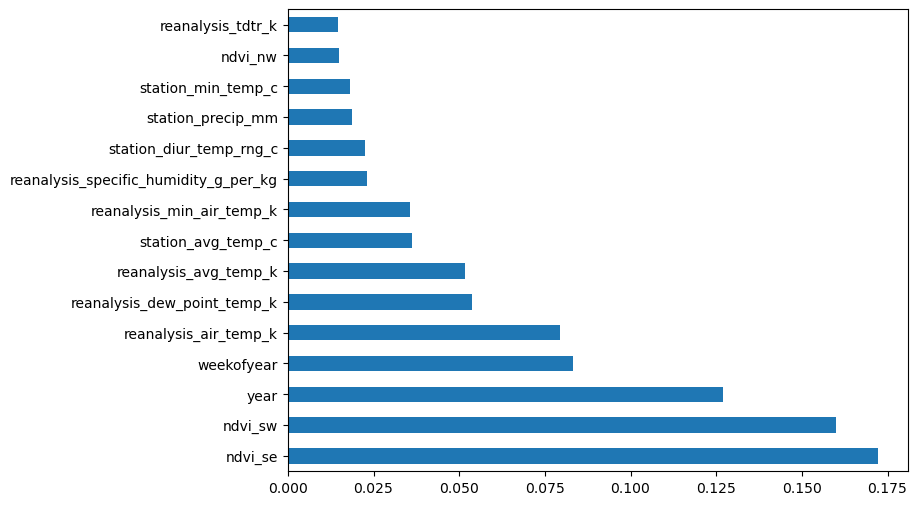

In [23]:
importances = pd.Series(rf.feature_importances_, index=X_train.columns)
importances.sort_values(ascending=False).head(15)
importances.sort_values(ascending=False).head(15).plot(kind='barh', figsize=(8,6))

In [25]:
#Adding lags
df = train.copy()  # train already includes total_cases and is cleaned
df = df.sort_values(["city", "year", "weekofyear"]).reset_index(drop=True)

In [27]:

for lag in [1, 2, 3]:
    df[f"lag_{lag}"] = df.groupby("city")["total_cases"].shift(lag)

In [29]:
df = df.groupby("city").ffill().bfill()

In [31]:
X = df.drop(columns=["total_cases"])
y = df["total_cases"]

In [33]:
X_train = X[X["year"] < 2008]
y_train = y[X["year"] < 2008]

X_valid = X[X["year"] == 2008]
y_valid = y[X["year"] == 2008]

In [35]:

rf = RandomForestRegressor(
    n_estimators=600,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_valid)
mae = mean_absolute_error(y_valid, y_pred)
print("MAE with lag features:", mae)

MAE with lag features: 6.223067632850243


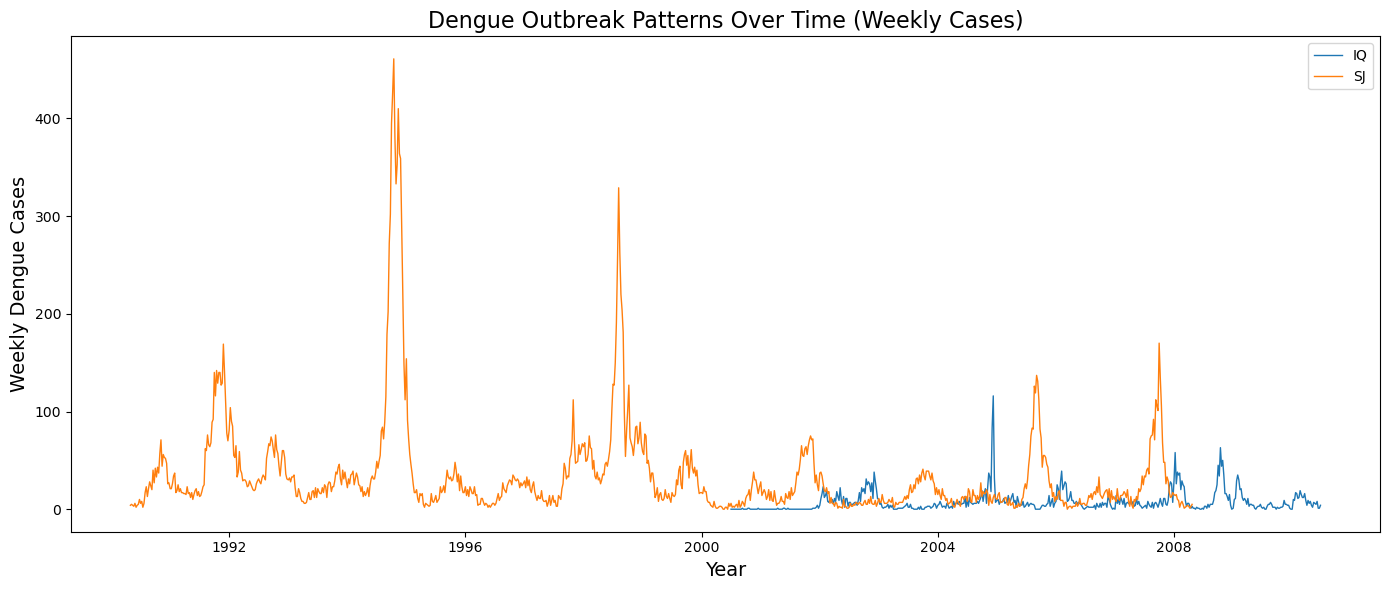

In [36]:

df = features_train.merge(labels_train, on=["city", "year", "weekofyear"])

df["week_start_date"] = pd.to_datetime(df["week_start_date"])

#Sorting properly
df = df.sort_values(["city", "week_start_date"]).reset_index(drop=True)

#Plotting dengue outbreaks over time
fig, ax = plt.subplots(figsize=(14,6))

for city in df["city"].unique():
    temp = df[df["city"] == city]
    ax.plot(temp["week_start_date"], temp["total_cases"], label=f"{city.upper()}", linewidth=1)

ax.set_title("Dengue Outbreak Patterns Over Time (Weekly Cases)", fontsize=16)
ax.set_xlabel("Year", fontsize=14)
ax.set_ylabel("Weekly Dengue Cases", fontsize=14)
ax.legend()
plt.tight_layout()
plt.show()

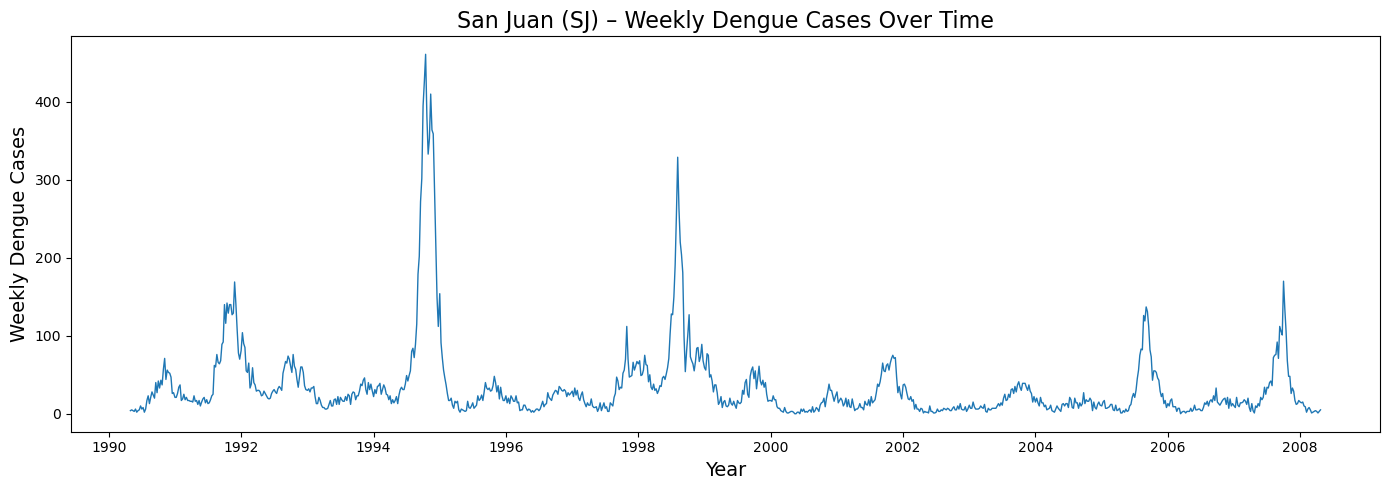

In [37]:
sj = df[df["city"] == "sj"]

plt.figure(figsize=(14,5))
plt.plot(sj["week_start_date"], sj["total_cases"], linewidth=1)
plt.title("San Juan (SJ) – Weekly Dengue Cases Over Time", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Weekly Dengue Cases", fontsize=14)
plt.tight_layout()
plt.show()

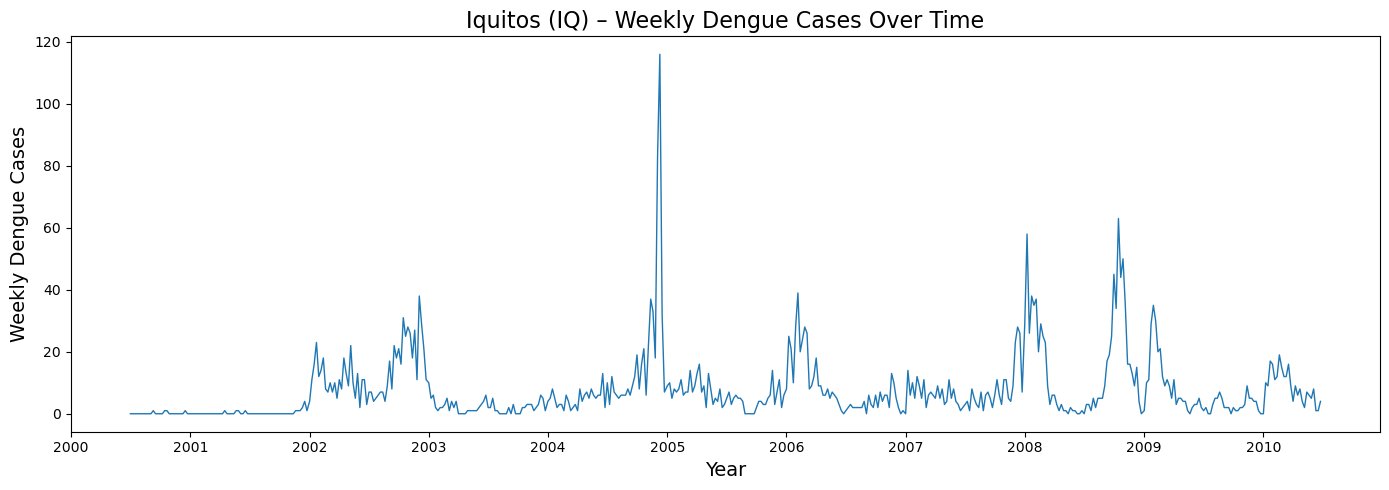

In [38]:
iq = df[df["city"] == "iq"]

plt.figure(figsize=(14,5))
plt.plot(iq["week_start_date"], iq["total_cases"], linewidth=1)
plt.title("Iquitos (IQ) – Weekly Dengue Cases Over Time", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Weekly Dengue Cases", fontsize=14)
plt.tight_layout()
plt.show()

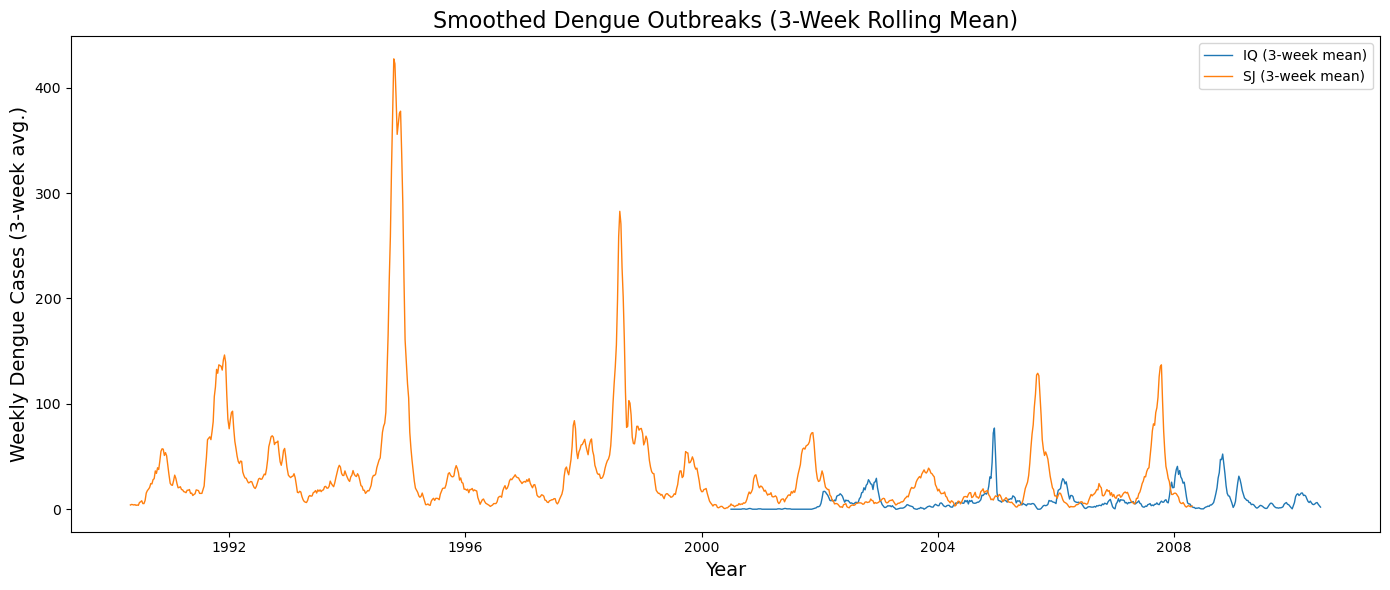

In [40]:
df_roll = df.copy()

df_roll["roll_3"] = (
    df_roll.groupby("city")["total_cases"]
          .rolling(3, min_periods=1)
          .mean()
          .reset_index(0, drop=True)
)

plt.figure(figsize=(14,6))
for city in df_roll["city"].unique():
    temp = df_roll[df_roll["city"] == city]
    plt.plot(temp["week_start_date"], temp["roll_3"], label=f"{city.upper()} (3-week mean)", linewidth=1)

plt.title("Smoothed Dengue Outbreaks (3-Week Rolling Mean)", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Weekly Dengue Cases (3-week avg.)", fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

In [44]:

#HUMIDITY
median_h = df["reanalysis_specific_humidity_g_per_kg"].median()
high_h = df[df["reanalysis_specific_humidity_g_per_kg"] >= median_h]["total_cases"]
low_h  = df[df["reanalysis_specific_humidity_g_per_kg"] <  median_h]["total_cases"]

z_h, p_h = ztest(high_h, low_h, alternative='larger')
print("Humidity Z-test:")
print("Z =", z_h)
print("p-value =", p_h)

Humidity Z-test:
Z = 4.260841829693289
p-value = 1.0182916590838494e-05


In [47]:

median_t = df["reanalysis_air_temp_k"].median()
high_t = df[df["reanalysis_air_temp_k"] >= median_t]["total_cases"]
low_t  = df[df["reanalysis_air_temp_k"] <  median_t]["total_cases"]

z_t, p_t = ztest(high_t, low_t, alternative='larger')
print("\nAir Temperature Z-test:")
print("Z =", z_t)
print("p-value =", p_t)


Air Temperature Z-test:
Z = 9.123971843333281
p-value = 3.62101933925904e-20


In [49]:
median_t2 = df["station_avg_temp_c"].median()
high_t2 = df[df["station_avg_temp_c"] >= median_t2]["total_cases"]
low_t2  = df[df["station_avg_temp_c"] <  median_t2]["total_cases"]

z_t2, p_t2 = ztest(high_t2, low_t2, alternative='larger')
print("\nStation Avg Temperature Z-test:")
print("Z =", z_t2)
print("p-value =", p_t2)


Station Avg Temperature Z-test:
Z = 4.172921368581432
p-value = 1.5035937366241072e-05


In [51]:
median_ndvi = df["ndvi_se"].median()
high_nd = df[df["ndvi_se"] >= median_ndvi]["total_cases"]
low_nd  = df[df["ndvi_se"] <  median_ndvi]["total_cases"]

z_nd, p_nd = ztest(high_nd, low_nd, alternative='larger')
print("\nNDVI (SE) Z-test:")
print("Z =", z_nd)
print("p-value =", p_nd)


NDVI (SE) Z-test:
Z = -6.041207022993868
p-value = 0.9999999992351722


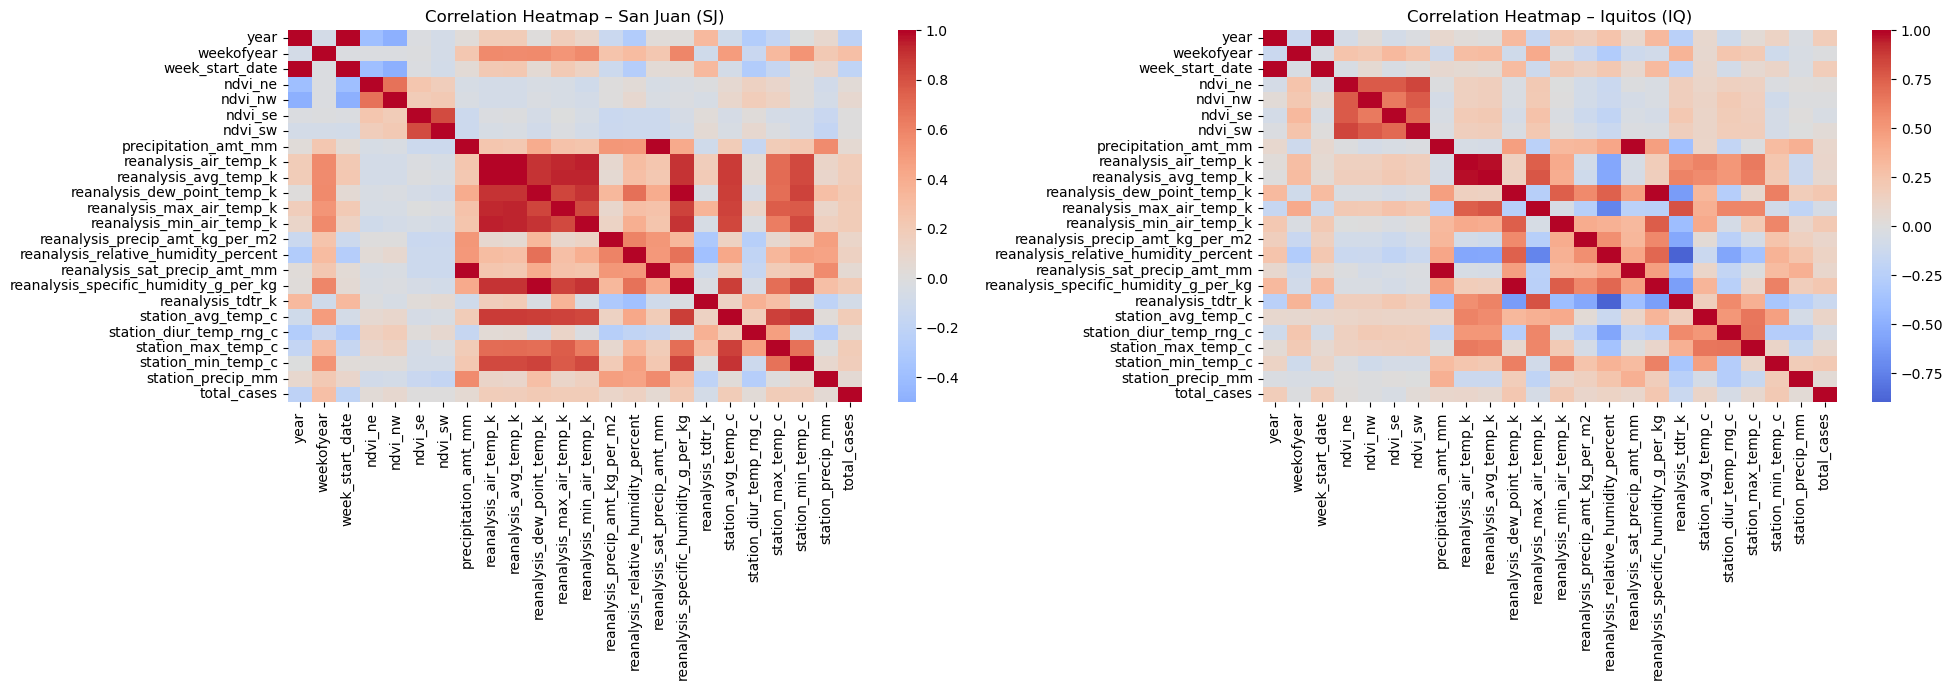

In [53]:

sj = df[df["city"] == "sj"].drop(columns=["city"])
iq = df[df["city"] == "iq"].drop(columns=["city"])

fig, axes = plt.subplots(1, 2, figsize=(20, 7))

sns.heatmap(sj.corr(), cmap='coolwarm', center=0, ax=axes[0])
axes[0].set_title("Correlation Heatmap – San Juan (SJ)")

sns.heatmap(iq.corr(), cmap='coolwarm', center=0, ax=axes[1])
axes[1].set_title("Correlation Heatmap – Iquitos (IQ)")

plt.tight_layout()
plt.show()

In [55]:


#Loading and merging
features = pd.read_csv("dengue_features_train.csv")
labels   = pd.read_csv("dengue_labels_train.csv")
df = features.merge(labels, on=["city","year","weekofyear"])
df = df[[
    "city",
    "total_cases",
    "reanalysis_specific_humidity_g_per_kg",
    "reanalysis_air_temp_k",
    "station_avg_temp_c",
    "ndvi_se"
]].dropna()

#per-city Z-test
def perform_ztest(city, variable, alternative="larger"):
    sub = df[df["city"] == city]
    med = sub[variable].median()
    high = sub[sub[variable] >= med]["total_cases"]
    low  = sub[sub[variable] <  med]["total_cases"]
    z, p = ztest(high, low, alternative=alternative)
    return z, p

results = {}

#SJ tests
results["SJ_humidity"] = perform_ztest("sj", "reanalysis_specific_humidity_g_per_kg")
results["SJ_airtemp"] = perform_ztest("sj", "reanalysis_air_temp_k")
results["SJ_stationtemp"] = perform_ztest("sj", "station_avg_temp_c")
#NDVI uses alternative='smaller' because high NDVI reduces dengue
results["SJ_ndvi"] = perform_ztest("sj", "ndvi_se", alternative="smaller")

#IQ tests
results["IQ_humidity"] = perform_ztest("iq", "reanalysis_specific_humidity_g_per_kg")
results["IQ_airtemp"] = perform_ztest("iq", "reanalysis_air_temp_k")
results["IQ_stationtemp"] = perform_ztest("iq", "station_avg_temp_c")
results["IQ_ndvi"] = perform_ztest("iq", "ndvi_se", alternative="smaller")

results

{'SJ_humidity': (7.4157383858582095, 6.047452020131212e-14),
 'SJ_airtemp': (6.5900564563074, 2.198296796962925e-11),
 'SJ_stationtemp': (5.860655588217402, 2.3052166298880387e-09),
 'SJ_ndvi': (0.2442481552092376, 0.5964806831469195),
 'IQ_humidity': (5.607521123794575, 1.0262248474815662e-08),
 'IQ_airtemp': (1.742902251306624, 0.0406753453681532),
 'IQ_stationtemp': (2.486233417661096, 0.00645516277442167),
 'IQ_ndvi': (-1.2320127707039217, 0.10897215683059847)}

In [57]:

Xtr = pd.read_csv("dengue_features_train.csv")
ytr = pd.read_csv("dengue_labels_train.csv")
df  = Xtr.merge(ytr, on=["city","year","weekofyear"])

df["week_start_date"] = pd.to_datetime(df["week_start_date"])
df = df.sort_values(["city","week_start_date"]).reset_index(drop=True)
fill_cols = [c for c in df.columns if c != "city"]
df[fill_cols] = df.groupby("city")[fill_cols].ffill().bfill()

targets = ["total_cases"]
vars_to_test = [
    "reanalysis_specific_humidity_g_per_kg",   
    "reanalysis_air_temp_k",                   
    "station_avg_temp_c",                      
]


def bayes_diff_prob(x_high, x_low, n_sims=20000, m0=0.0, s0=5.0, a0=2.0, b0=2.0):
    x_high = np.asarray(x_high); x_low = np.asarray(x_low)

    def sample_posterior(x):
        n = len(x)
        xbar = x.mean()
        ss = ((x - xbar)**2).sum()

        #Posterior hyperparams (Normal-Inverse-Gamma conjugacy)
        s0_2 = s0**2
        sn_2 = 1.0 / (n + 1.0/s0_2)
        mn = sn_2 * (n*xbar + m0/s0_2)
        an = a0 + n/2.0
        bn = b0 + 0.5*ss + 0.5*(n*(xbar-m0)**2)/(1.0 + n*s0_2)

        #Sample sigma^2 from Inv-Gamma = 1 / Gamma(an, scale=1/bn)
        sig2 = 1.0 / np.random.gamma(shape=an, scale=1.0/bn, size=n_sims)
        
        mu = np.random.normal(loc=mn, scale=np.sqrt(sig2*sn_2), size=n_sims)
        return mu, sig2

    mu_h, _ = sample_posterior(x_high)
    mu_l, _ = sample_posterior(x_low)

    diff = mu_h - mu_l
    prob = (diff > 0).mean()
    return prob, diff


for v in vars_to_test:
    med = df[v].median()
    y = np.log1p(df["total_cases"].values)  # stabilize counts
    high = y[df[v].values >= med]
    low  = y[df[v].values <  med]

    prob, diff = bayes_diff_prob(high, low, n_sims=30000)

    ci = np.quantile(diff, [0.025, 0.975])

    print(f"\nVariable: {v}")
    print(f"P(mean_high > mean_low) = {prob:.4f}")
    print(f"95% credible interval for (mean_high - mean_low): [{ci[0]:.4f}, {ci[1]:.4f}]  (log1p scale)")


Variable: reanalysis_specific_humidity_g_per_kg
P(mean_high > mean_low) = 1.0000
95% credible interval for (mean_high - mean_low): [0.2519, 0.5027]  (log1p scale)

Variable: reanalysis_air_temp_k
P(mean_high > mean_low) = 1.0000
95% credible interval for (mean_high - mean_low): [0.5829, 0.8275]  (log1p scale)

Variable: station_avg_temp_c
P(mean_high > mean_low) = 0.9999
95% credible interval for (mean_high - mean_low): [0.1122, 0.3667]  (log1p scale)


In [59]:


Xtr = pd.read_csv("dengue_features_train.csv")
ytr = pd.read_csv("dengue_labels_train.csv")
df  = Xtr.merge(ytr, on=["city","year","weekofyear"])

df["week_start_date"] = pd.to_datetime(df["week_start_date"])
df = df.sort_values(["city","week_start_date"]).reset_index(drop=True)
fill_cols = [c for c in df.columns if c != "city"]
df[fill_cols] = df.groupby("city")[fill_cols].ffill().bfill()

# Encode city (no per-city split, just a covariate)
le = LabelEncoder()
df["city_enc"] = le.fit_transform(df["city"])

# Choose predictors
predictors = [
    "city_enc",
    "weekofyear",
    "reanalysis_specific_humidity_g_per_kg",
    "reanalysis_air_temp_k",
    "station_avg_temp_c",
    "station_precip_mm",
    "ndvi_se",
]

X = df[predictors].values
y = np.log1p(df["total_cases"].values)  # regression target

model = BayesianRidge()
model.fit(X, y)

coef = model.coef_
print("BayesianRidge coefficients (on log1p(cases)):")
for name, c in zip(predictors, coef):
    print(f"{name:35s} {c:+.5f}")

#Posterior predictive mean/std for the training set (quick check)
yhat, ystd = model.predict(X, return_std=True)
print("\nAvg predictive std (log1p scale):", float(np.mean(ystd)))

BayesianRidge coefficients (on log1p(cases)):
city_enc                            +1.45179
weekofyear                          +0.00813
reanalysis_specific_humidity_g_per_kg +0.21039
reanalysis_air_temp_k               -0.02187
station_avg_temp_c                  -0.05866
station_precip_mm                   +0.00006
ndvi_se                             -0.76396

Avg predictive std (log1p scale): 10.698876125601624


In [61]:

features_train = pd.read_csv("dengue_features_train.csv")
labels_train   = pd.read_csv("dengue_labels_train.csv")

#Merge
df = features_train.merge(labels_train, on=["city", "year", "weekofyear"])

#Sort
df["week_start_date"] = pd.to_datetime(df["week_start_date"])
df = df.sort_values(["city", "week_start_date"]).reset_index(drop=True)

#Filling missing values per city
cols_to_fill = [c for c in df.columns if c != "city"]
df[cols_to_fill] = (
    df.groupby("city")[cols_to_fill]
      .ffill()
      .bfill()
)

#Encoding city
city_encoder = LabelEncoder()
df["city_enc"] = city_encoder.fit_transform(df["city"]) 

for lag in [1, 2, 3]:
    df[f"lag_{lag}"] = (
        df.groupby("city")["total_cases"]
          .shift(lag)
    )

df = df.dropna(subset=[f"lag_{lag}" for lag in [1, 2, 3]]).reset_index(drop=True)

#X and y
drop_cols = ["total_cases", "city", "week_start_date"]
X = df.drop(columns=drop_cols)
y = df["total_cases"]

In [63]:
train_mask = df["year"] < 2008
valid_mask = df["year"] == 2008

X_train, y_train = X[train_mask], y[train_mask]
X_valid, y_valid = X[valid_mask], y[valid_mask]

print("Train shape:", X_train.shape)
print("Valid shape:", X_valid.shape)

Train shape: (1303, 26)
Valid shape: (69, 26)


In [65]:
xgb_model = xgb.XGBRegressor(
    n_estimators=800,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1,
)

xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.03, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=800,
             n_jobs=-1, num_parallel_tree=None, ...)

In [66]:
#Predicting
y_pred_xgb = xgb_model.predict(X_valid)

#MAE
mae_xgb = mean_absolute_error(y_valid, y_pred_xgb)
print("XGBoost MAE (2008):", mae_xgb)

#MAE per city
valid_df = X_valid.copy()
valid_df["true_cases"] = y_valid.values
valid_df["pred_xgb"] = y_pred_xgb

mae_by_city = (
    valid_df
    .groupby("city_enc")[["true_cases", "pred_xgb"]]
    .apply(lambda g: mean_absolute_error(g["true_cases"], g["pred_xgb"]))
)

print("\nMAE by city (encoded):")
print(mae_by_city)
print("City encoding:", dict(enumerate(city_encoder.classes_)))

XGBoost MAE (2008): 5.7956461906433105

MAE by city (encoded):
city_enc
0    6.898043
1    2.423613
dtype: float64
City encoding: {0: 'iq', 1: 'sj'}


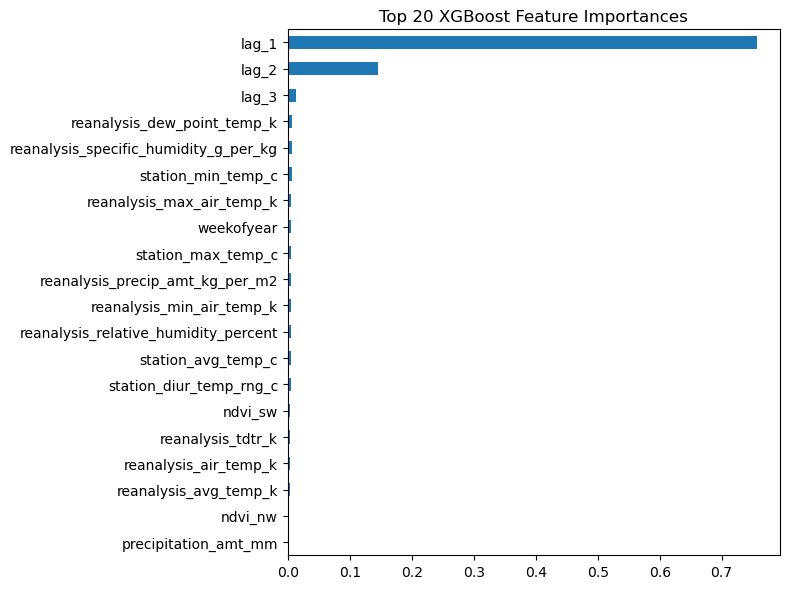

In [69]:
importances = pd.Series(
    xgb_model.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False).head(20)

plt.figure(figsize=(8,6))
importances.plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Top 20 XGBoost Feature Importances")
plt.tight_layout()
plt.show()

In [71]:

features_train = pd.read_csv("dengue_features_train.csv")
labels_train   = pd.read_csv("dengue_labels_train.csv")

df = features_train.merge(labels_train, on=["city", "year", "weekofyear"])

df["week_start_date"] = pd.to_datetime(df["week_start_date"])
df = df.sort_values(["city", "week_start_date"]).reset_index(drop=True)

cols_to_fill = [c for c in df.columns if c != "city"]
df[cols_to_fill] = (
    df.groupby("city")[cols_to_fill]
      .ffill()
      .bfill()
)


city_encoder = LabelEncoder()
df["city_enc"] = city_encoder.fit_transform(df["city"])   # {'iq':0, 'sj':1}

for lag in [1, 2, 3]:
    df[f"lag_{lag}"] = (
        df.groupby("city")["total_cases"]
          .shift(lag)
    )

#Dropping initial rows with missing lags
df = df.dropna(subset=[f"lag_{lag}" for lag in [1,2,3]]).reset_index(drop=True)

drop_cols = ["total_cases", "city", "week_start_date"]
X = df.drop(columns=drop_cols)
y = df["total_cases"]

train_mask = df["year"] < 2008
valid_mask = df["year"] == 2008

X_train, y_train = X[train_mask], y[train_mask]
X_valid, y_valid = X[valid_mask], y[valid_mask]

print("Train shape:", X_train.shape)
print("Valid shape:", X_valid.shape)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

mlp = MLPRegressor(
    hidden_layer_sizes=(64, 32),  
    activation='relu',
    solver='adam',
    learning_rate_init=0.001,
    alpha=1e-3,          
    max_iter=500,
    random_state=42,
    early_stopping=True,
    n_iter_no_change=20,
)

mlp.fit(X_train_scaled, y_train)


y_pred_mlp = mlp.predict(X_valid_scaled)
mae_mlp = mean_absolute_error(y_valid, y_pred_mlp)
print("MLP Neural Network MAE (2008):", mae_mlp)

# Per-city MAE
valid_df = pd.DataFrame({
    "city_enc": X_valid["city_enc"].values,
    "true_cases": y_valid.values,
    "pred_mlp": y_pred_mlp
})

mae_by_city_mlp = (
    valid_df
    .groupby("city_enc")[["true_cases", "pred_mlp"]]
    .apply(lambda g: mean_absolute_error(g["true_cases"], g["pred_mlp"]))
)

print("\nMLP MAE by city (encoded):")
print(mae_by_city_mlp)
print("City encoding:", dict(enumerate(city_encoder.classes_)))

Train shape: (1303, 26)
Valid shape: (69, 26)
MLP Neural Network MAE (2008): 6.532651311192504

MLP MAE by city (encoded):
city_enc
0    7.598815
1    3.271444
dtype: float64
City encoding: {0: 'iq', 1: 'sj'}


In [73]:

features_train = pd.read_csv("dengue_features_train.csv")
labels_train   = pd.read_csv("dengue_labels_train.csv")
features_test  = pd.read_csv("dengue_features_test.csv")

train = features_train.merge(labels_train, on=["city","year","weekofyear"])


train["week_start_date"] = pd.to_datetime(train["week_start_date"])
features_test["week_start_date"] = pd.to_datetime(features_test["week_start_date"])

train = train.sort_values(["city","week_start_date"]).reset_index(drop=True)
features_test = features_test.sort_values(["city","week_start_date"]).reset_index(drop=True)

cols_to_fill_train = [c for c in train.columns if c not in ["city"]]
train[cols_to_fill_train] = (
    train.groupby("city")[cols_to_fill_train]
         .ffill()
         .bfill()
)

cols_to_fill_test = [c for c in features_test.columns if c not in ["city"]]
features_test[cols_to_fill_test] = (
    features_test.groupby("city")[cols_to_fill_test]
                .ffill()
                .bfill()
)

le = LabelEncoder()
train["city_enc"] = le.fit_transform(train["city"])
features_test["city_enc"] = le.transform(features_test["city"])

drop_cols_train = ["total_cases", "city", "week_start_date"]
drop_cols_test  = ["city", "week_start_date"]

X_train = train.drop(columns=drop_cols_train)
y_train = train["total_cases"]

X_test = features_test.drop(columns=drop_cols_test)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


#FINAL XGBoost model

model = xgb.XGBRegressor(
    n_estimators=800,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)


test_pred = model.predict(X_test)
test_pred = np.clip(test_pred, 0, None)      
test_pred = np.round(test_pred).astype(int) 

submission = features_test[["city", "year", "weekofyear"]].copy()
submission["total_cases"] = test_pred

submission = submission.sort_values(["city", "year", "weekofyear"])
submission.to_csv("dengue_submission_xgb_nolags.csv", index=False)

print("Saved: dengue_submission_xgb_nolags.csv")
submission.head()

X_train shape: (1456, 23)
X_test shape: (416, 23)
Saved: dengue_submission_xgb_nolags.csv


,city,year,weekofyear,total_cases
0,iq,2010,26,6
1,iq,2010,27,1
2,iq,2010,28,6
3,iq,2010,29,3
4,iq,2010,30,3


In [75]:
submission = pd.read_csv("dengue_submission_xgb_nolags.csv")
submission = submission.sort_values(["city", "year", "weekofyear"])

submission.head(20)

,city,year,weekofyear,total_cases
0,iq,2010,26,6
1,iq,2010,27,1
2,iq,2010,28,6
3,iq,2010,29,3
4,iq,2010,30,3
5,iq,2010,31,3
6,iq,2010,32,9
7,iq,2010,33,4
8,iq,2010,34,2
9,iq,2010,35,6


In [77]:
submission.groupby("city")["total_cases"].describe()

,count,mean,std,min,25%,50%,75%,max
city,,,,,,,,
iq,156.0,8.532051,6.342300,0.0,4.0,7.0,12.25,48.0
sj,260.0,29.976923,24.526391,2.0,11.0,21.0,40.25,118.0


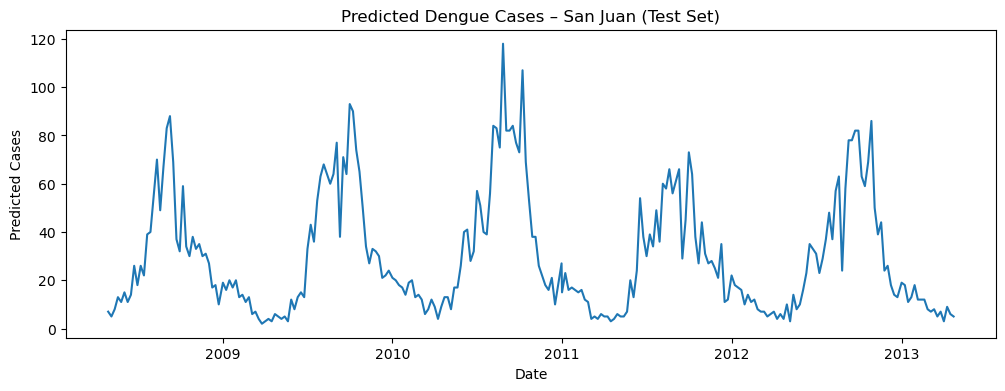

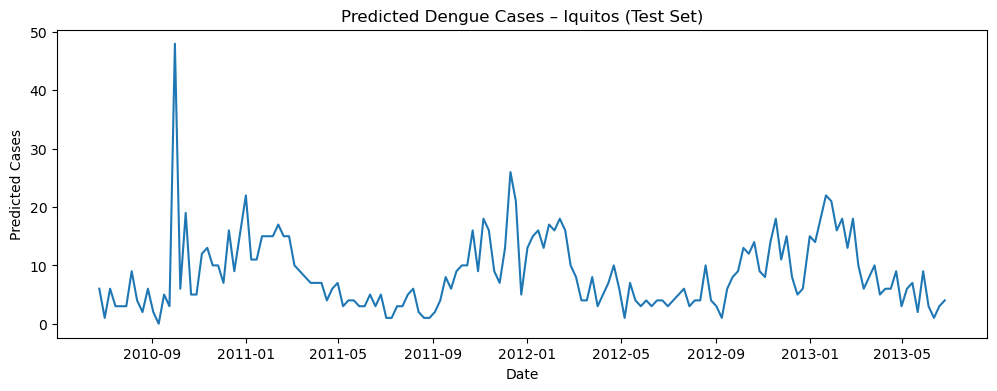

In [79]:

submission["date"] = pd.to_datetime(
    submission["year"].astype(str) + "-01-01"
) + pd.to_timedelta((submission["weekofyear"] - 1) * 7, unit="D")

#San Juan
sj = submission[submission["city"] == "sj"]
plt.figure(figsize=(12,4))
plt.plot(sj["date"], sj["total_cases"])
plt.title("Predicted Dengue Cases – San Juan (Test Set)")
plt.xlabel("Date")
plt.ylabel("Predicted Cases")
plt.show()

#Iquitos
iq = submission[submission["city"] == "iq"]
plt.figure(figsize=(12,4))
plt.plot(iq["date"], iq["total_cases"])
plt.title("Predicted Dengue Cases – Iquitos (Test Set)")
plt.xlabel("Date")
plt.ylabel("Predicted Cases")
plt.show()

In [83]:
viz = df[valid_mask][
    ["city", "year", "weekofyear", "week_start_date", "total_cases"]
].copy()

viz["pred"] = y_pred  # y_pred from the model you just ran

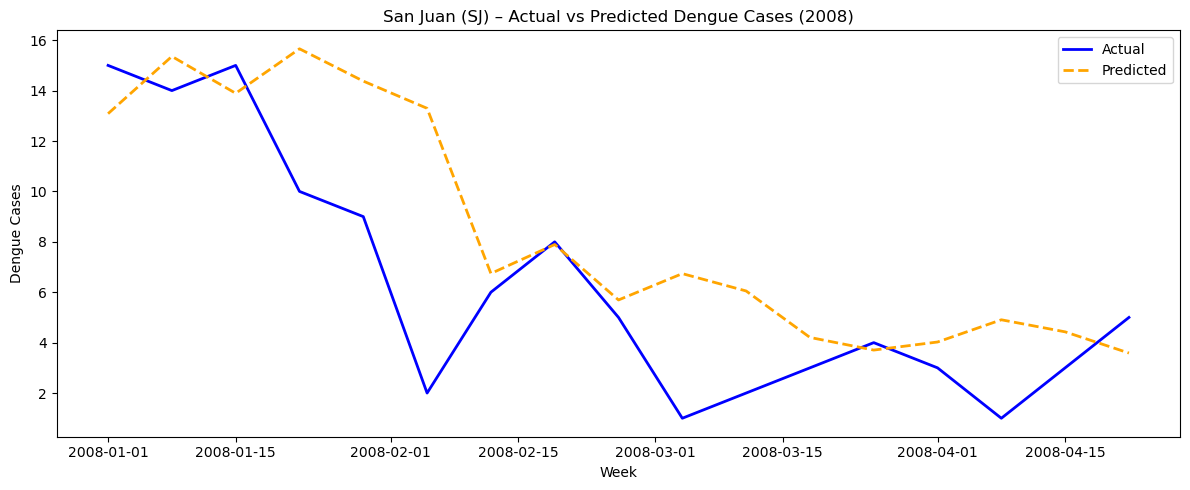

In [85]:
plt.figure(figsize=(12,5))

sj = viz[viz["city"] == "sj"]

plt.plot(
    sj["week_start_date"],
    sj["total_cases"],
    color="blue",
    linewidth=2,
    label="Actual"
)

plt.plot(
    sj["week_start_date"],
    sj["pred"],
    color="orange",
    linewidth=2,
    linestyle="--",
    label="Predicted"
)

plt.title("San Juan (SJ) – Actual vs Predicted Dengue Cases (2008)")
plt.xlabel("Week")
plt.ylabel("Dengue Cases")
plt.legend()
plt.tight_layout()
plt.show()

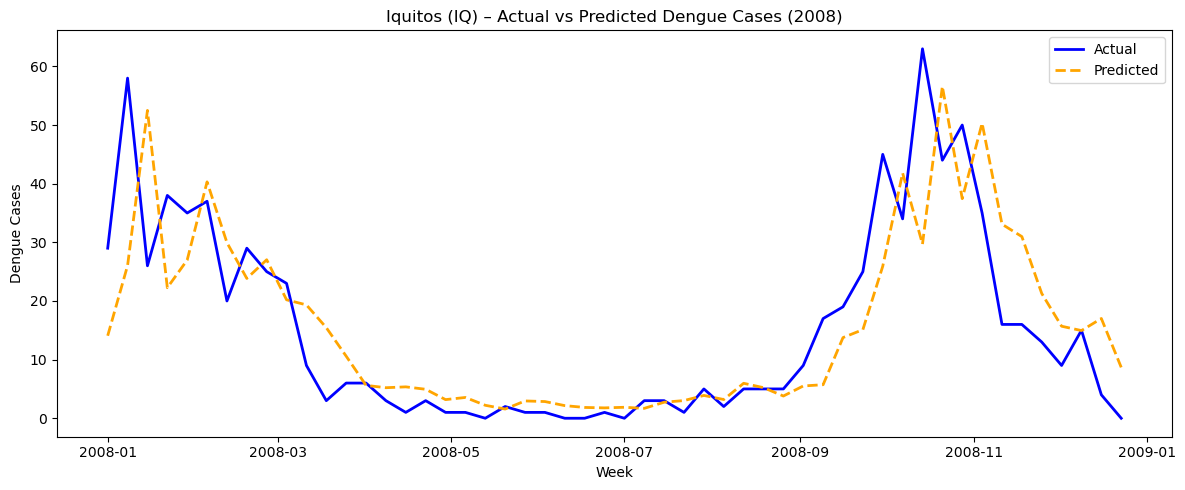

In [87]:
plt.figure(figsize=(12,5))

iq = viz[viz["city"] == "iq"]

plt.plot(
    iq["week_start_date"],
    iq["total_cases"],
    color="blue",
    linewidth=2,
    label="Actual"
)

plt.plot(
    iq["week_start_date"],
    iq["pred"],
    color="orange",
    linewidth=2,
    linestyle="--",
    label="Predicted"
)

plt.title("Iquitos (IQ) – Actual vs Predicted Dengue Cases (2008)")
plt.xlabel("Week")
plt.ylabel("Dengue Cases")
plt.legend()
plt.tight_layout()
plt.show()